In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet

2025-01-12 16:08:54.072890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 16:08:54.917061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-01-12 16:08:54.917137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-01-12 16:08:54.917144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [7]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)


In [2]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

In [ ]:
def train_resnet(X_train, Y_train, folds, layers=10, batch_size=32, epochs=10, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Trains a ResNet model on the given data without cross-validation.
    
    Args:
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        X_val (numpy.ndarray): The validation data.
        Y_val (numpy.ndarray): The validation labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    train_index = np.where(folds != 7)[0]
    val_index = np.where(folds == 7)[0]
    
    
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    
    # make model
    out, _ = resnet.model(X_input, num_classes=num_classes, filters=[16, 16], kernels=[5, 3], layers=layers, hidden_units=128)
    model = keras.Model(inputs=X_input, outputs=out)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    
    # print model summary
    model.summary()


    # train
    data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
    history = model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=X_train_fold.shape[0]//batch_size, verbose=1)
    
    # evaluate
    val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
    y_pred = model.predict(X_val_fold)
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
    val_auc = roc_auc_score(Y_val_fold, y_pred)
        
    # evaluate on test set
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
    y_pred = model.predict(X_test)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    test_auc = roc_auc_score(Y_test, y_pred)
    
    # save model
    # model.save_weights(f'model-weights/{name}')
    
    # plot training history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')   
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
   
    print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc},Test F1 Score: {test_f1}")
    
    return model

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_6[0][0]']                
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation_15 (Activation)     (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                            

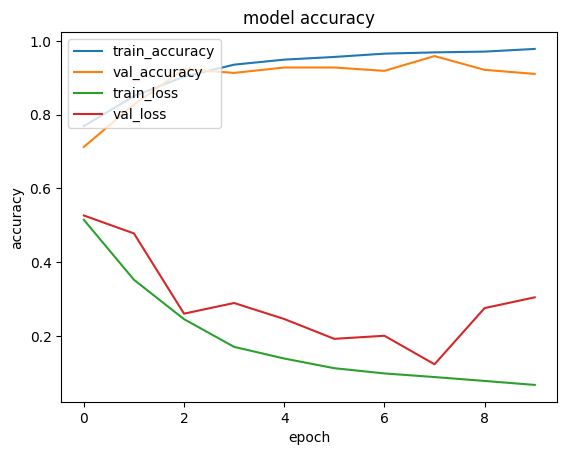

NameError: name 'val_auc' is not defined

In [21]:
# 1 resnet block
train_resnet(X_train, Y_train, folds_train, layers=1, batch_size=32, epochs=10, learning_rate=0.001, num_classes=1, name="resnet_1.h5")

In [ ]:
#